In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize
from tqdm import tqdm
import pandas as pd

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.utils import *
from src.analysis import *
from src.approximation import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

# Global parameters

In [2]:
# specify system parameters
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'seed': 1001 # random seed 
}

In [3]:
# analysis
epsilon=0.1
sigma=0.01
window=10

lams_data = 1 - 10 ** np.linspace(0, -4, 20)
print(lams_data)

params_results=params.copy()
params_results['epsilon']=epsilon
params_results['sigma']=sigma
params_results['window']=window

[0.         0.38415179 0.62073098 0.76642785 0.85615501 0.91141332
 0.94544405 0.96640182 0.97930862 0.98725725 0.9921524  0.99516707
 0.99702365 0.99816702 0.99887116 0.99930481 0.99957187 0.99973633
 0.99983762 0.9999    ]


In [4]:
# load relevant information from database
import sqlite3
con = sqlite3.connect('./simulations.db')
cur = con.cursor()

# raise error
if exists_in_database(con,cur,'results', params_results):
    raise ValueError(f"Results already in database for params")

# load the path of the function approximation
beta_interpolations = pd.read_sql_query(f"SELECT * FROM beta_interpolation", con)
# select the relevant function approximation
beta_interpolation = beta_interpolations[(beta_interpolations['N']==params['N']) & (beta_interpolations['K']==params['K']) & (beta_interpolations['mu']==params['mu']) & (beta_interpolations['seed']==params['seed'])]
# if there is no such function approximation, raise error
if len(beta_interpolation)==0:
    raise ValueError(f"No function approximation in database for params")
# if there is more than one such function approximation, raise error
if len(beta_interpolation)>1:
    raise ValueError(f"Multiple function approximations in database for params")
# load the path of the simulation
file_beta_interpolation = beta_interpolation['filename'].values[0]
print(file_beta_interpolation)

./dat/neural_network_approximation_seed=1001.pkl


# Analysis of data

In [5]:
# For ML part
import torch
from torch import nn
sim_approx = FunctionApproximation(filename=file_beta_interpolation)

### Check that approximation yields distributed result around theoretical mean

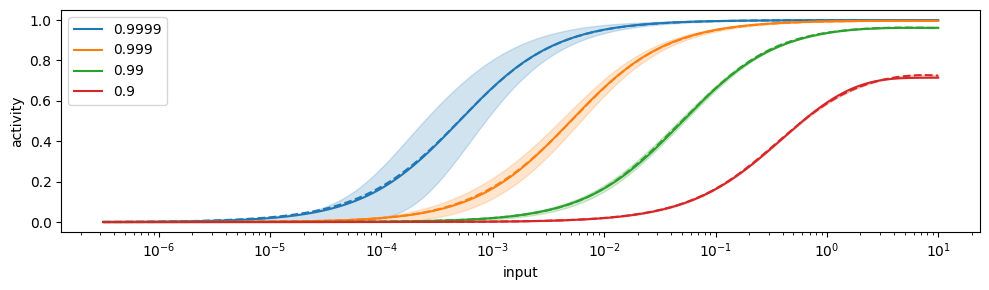

In [7]:
# for reference 
def a_inf(lam, mu, h):
    dt=1
    return mu*(1-np.exp(-h*dt))/(1-lam*(1-mu)-lam*mu*np.exp(-h*dt))

fig, axes = plt.subplots(1, 1, figsize=(10, 3))
hs = 10**np.linspace(-6.5, 1, 200)
for i, lam in enumerate([0.9999, 0.999, 0.99, 0.9]):
    # theory
    ref = axes.plot(hs, a_inf(lam, params['mu'], hs), label='{}'.format(lam))
    # simulation approximation with variance!
    avals, bvals = sim_approx(lam*np.ones_like(hs), window*np.ones_like(hs), hs)
    mean = avals/(avals+bvals)
    # calculate percentiles from stats.beta(a,b)
    beta = stats.beta(avals, bvals)
    percentile_25 = beta.ppf(0.25)
    percentile_50 = beta.ppf(0.5)
    percentile_75 = beta.ppf(0.75)
    axes.plot(hs, mean, color=ref[0].get_color(), linestyle='--')
    axes.fill_between(hs, percentile_25, percentile_75, color=ref[0].get_color(), alpha=0.2)
#axes.set_yscale("log")
axes.set_xscale("log")
axes.set_xlabel("input")
axes.set_ylabel("activity")
axes.legend()
plt.tight_layout()
plt.show()

### Convolution of beta distribution with Guassian 

In [8]:
N = sim_approx.params['N']
delta = 1/N
support = np.arange(0, 1+4*sigma, delta)
support = np.concatenate((-support[::-1], support[1:]))

# TODO: include loc and scale into params
loc = -0.0001	
scale = 1.0002

def ml_pmf(window, lam, h, verbose=False):
    a,b = sim_approx(lam, window, h)
    # pmf as difference of cdf to ensure that the pmf is normalized
    pmf_beta = np.diff(stats.beta.cdf(support, a, b, loc=loc, scale=scale))
    # convolution with a Gaussian distribution at every point of the support
    pmf_norm = stats.norm.pdf(support, 0, sigma)*delta
    return np.convolve(pmf_beta, pmf_norm, mode="same")

In [9]:
#create pandas dataframe
df = pd.DataFrame(columns=['lambda', 'number_discriminable', 'dynamic_range'])

# specify h_range (need to exclude the zero here because of logh fit)
# TODO: make this part of the params from the function approximation!
h_range = [10**-6.5, 10]

for i, lam in tqdm(enumerate(lams_data), total=len(lams_data)):
    # distribution is given by Beta-distribution specified by a and b
    def pmf_o_given_h(h):
        return ml_pmf(window, lam, h)

    pmf_ref_left = stats.norm.pdf(support, a_inf(lam, params['mu'], 0), sigma) * delta
    pmf_ref_right = stats.norm.pdf(support, a_inf(lam, params['mu'], 1e3), sigma) * delta
    hs_left = find_discriminable_inputs(
        pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon
    )
    hs_right = find_discriminable_inputs(
        pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right"
    )
    if len(hs_left) > 0 and len(hs_right) > 0:
        df.loc[i] = {
            "lambda": lam,
            "number_discriminable": 0.5 * (len(hs_left) + len(hs_right)),
            "dynamic_range": dynamic_range((hs_left[0], hs_right[0])),
        }
        # drs[i] = dynamic_range((hs_left[0], hs_right[0]))
        # nds[i] = 0.5 * (len(hs_left) + len(hs_right))
    else:
        df.loc[i] = {
            "lambda": lam,
            "number_discriminable": np.nan,
            "dynamic_range": np.nan,
        }

  0%|          | 0/20 [00:00<?, ?it/s]


NameError: name 'mu' is not defined

In [ ]:
# save dataframe to ASCI files (tab-separated)
filename = f"./dat/N={params_results['N']}_K={params_results['K']}_mu={params_results['mu']}/results_simulation_seed={params_results['seed']}_window={params_results['window']}_sigma={params_results['sigma']}_epsilon={params_results['epsilon']}.txt"
# create directory if it does not exist
os.makedirs(os.path.dirname(filename), exist_ok=True)
df.to_csv(f'{filename}', index=False, sep='\t')
params_results['filename']=filename

# store in database
con = sqlite3.connect('./simulations.db')
cur = con.cursor()
insert_into_database(con, cur, 'results', params_results)
con.close()

## Additional plots to check analysis

In [ ]:
skip analysis plots

SyntaxError: invalid syntax (3042702497.py, line 1)

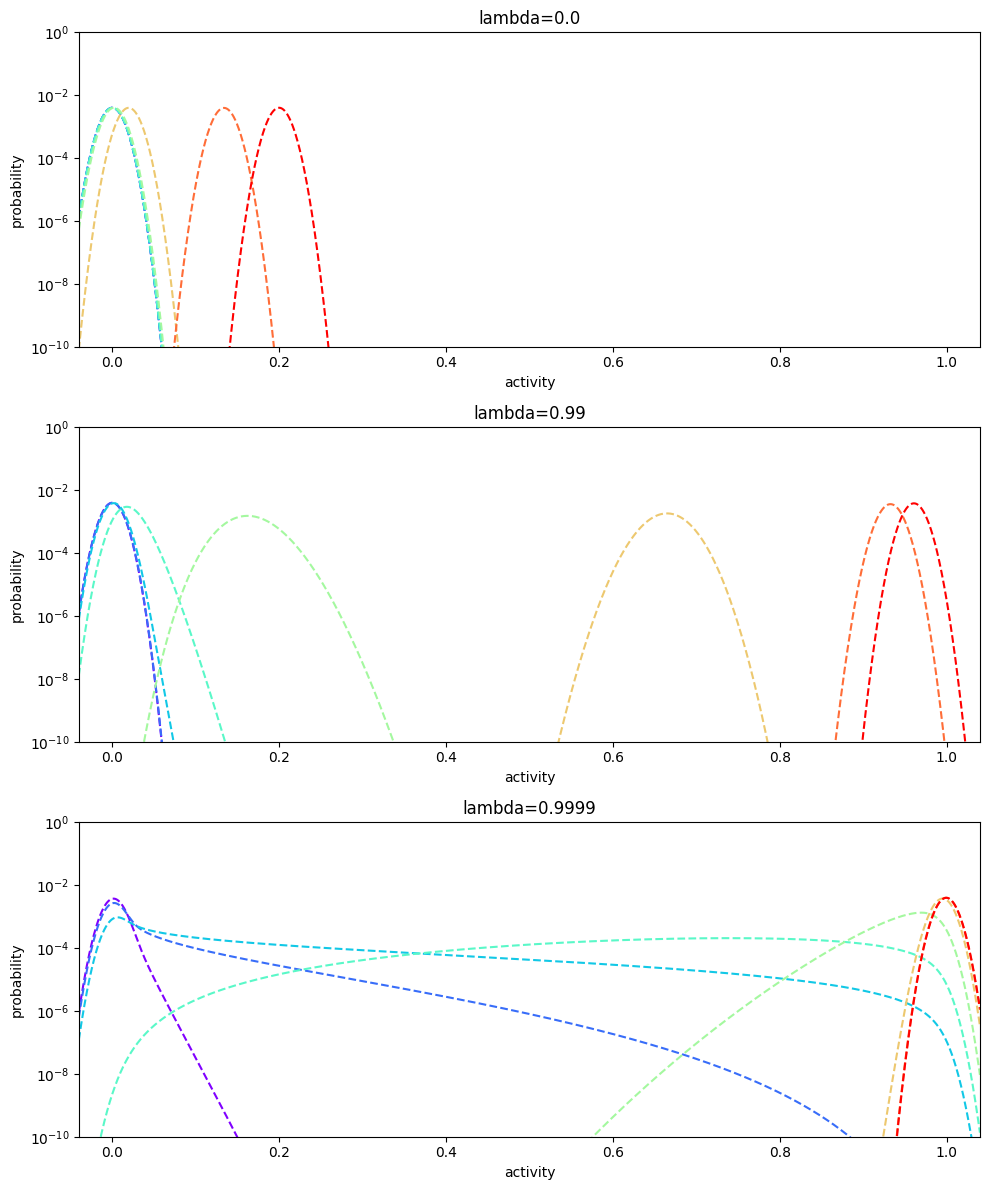

In [ ]:
from matplotlib.pyplot import cm

# plot resulting distributions for different values of h and epsilon
list_lam = [0.0, 0.99, 0.9999]
fig, axes = plt.subplots(len(list_lam),1, figsize=(10, 4*len(list_lam)))

list_hs = 10**np.linspace(-6, 1, 8)
for (i,lam) in enumerate(list_lam):
    color = iter(cm.rainbow(np.linspace(0, 1, len(list_hs))))
    for h in list_hs:
        c = next(color)
        # from ML dashed
        pmf_ml = ml_pmf(window, lam, h)
        axes[i].plot(support, pmf_ml, color=c, linestyle='--')
        axes[i].set_xlim(0-4*sigma,1+4*sigma)
        axes[i].set_xlabel("activity")
        axes[i].set_ylabel("probability")
        axes[i].set_title("lambda={}".format(lam))
        axes[i].set_yscale("log")
        axes[i].set_ylim(1e-10, 1e0)
plt.tight_layout()


From the interpolation model we can obtain estimates of the dynamic range and the resolution

Important: Need to be able to specify reference distributions! Else we cannot parse no/full activity for simulations. Reference could come from infinite-T solution plus Gaussian!

0.0
hs_left:  [0.1323512989230912, 0.27845940744987974, 0.4473609720528709, 0.6564086914935261, 0.9370948606043044, 1.3655744452527596]
hs_right:  [1.9272217221554335, 1.2320579060344925, 0.8547079581041453, 0.5970923817248918, 0.400633383526061, 0.23899600011564212]


(-0.04, 1.04)

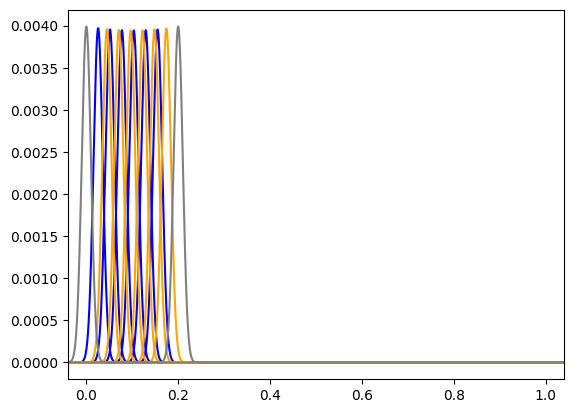

In [ ]:
# test discriminable intervals
lam = 0.0
window = 1 
def _pmf(h):
    return ml_pmf(window, lam, h)

# has to be in range of data! 
h_range=[10**-7,10]
# pmf from Gaussians around mean-field solution for h=0 and h->infty
# support defined above and needs to be consistent with the ml_pmf function!
print(a_inf(lam, mu, 0))
pmf_ref_left = stats.norm.pdf(support, a_inf(lam, mu, 0), sigma)*delta
pmf_ref_right = stats.norm.pdf(support, a_inf(lam, mu, 1e3), sigma)*delta

hs_left = find_discriminable_inputs(_pmf, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="left")
print("hs_left: ", hs_left)
for h in hs_left:
    plt.plot(support, _pmf(h), color="blue")

hs_right = find_discriminable_inputs(_pmf, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
print("hs_right: ", hs_right)
for h in hs_right:
    plt.plot(support, _pmf(h), color="orange")

plt.plot(support, pmf_ref_left, color="gray")
plt.plot(support, pmf_ref_right, color="gray")
plt.xlim(0-4*sigma,1+4*sigma)

# plt.legend()

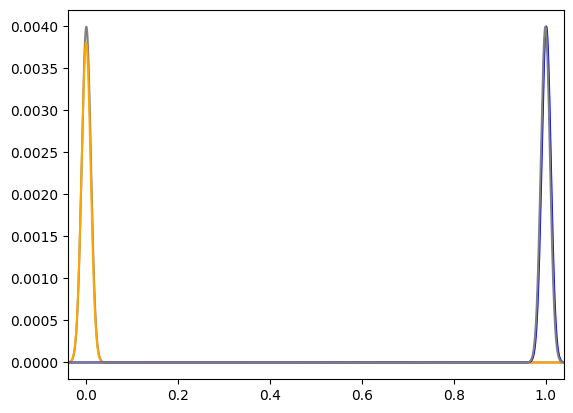

hs from left
possible solution: h=0.00014642244268902262 with overlap to end of 0.00036131173848048966 ... accepted
possible solution: h=0.0014391328045296468 with overlap to end of 0.009653638781501717 ... accepted
possible solution: h=0.010411023009432 with overlap to end of 0.11969698048953048 ... rejected
hs from right
possible solution: h=0.00872620972947351 with overlap to end of 1.677185009280933e-32 ... accepted
possible solution: h=0.0012114569363611786 with overlap to end of 2.977564726885441e-06 ... accepted
possible solution: h=0.00011427100958522482 with overlap to end of 0.12901152231231267 ... rejected
[0.00014642244268902262, 0.0014391328045296468]


In [ ]:
# check large lambda in more detail why there is no discriminable points when coming from left
lam = 0.0
window=1
def pmf_o_given_h(h):
    return ml_pmf(window, lam, h)
h_range=[10**-7, 10]
pmf_ref_left = stats.norm.pdf(support, a_inf(lam, mu, 0), sigma)*delta
pmf_ref_right = stats.norm.pdf(support, a_inf(lam, mu, 1e3), sigma)*delta
plt.plot(support, pmf_ref_left, color="gray")
plt.plot(support, pmf_o_given_h(h_range[0]), color="orange")
plt.plot(support, pmf_o_given_h(h_range[-1]), color="blue")
plt.plot(support, pmf_ref_right, color="gray")
plt.xlim(0-4*sigma,1+4*sigma)
plt.show()

print("hs from left")
hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="left", verbose=True)
print("hs from right")
hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right", verbose=True)
print(hs_left)

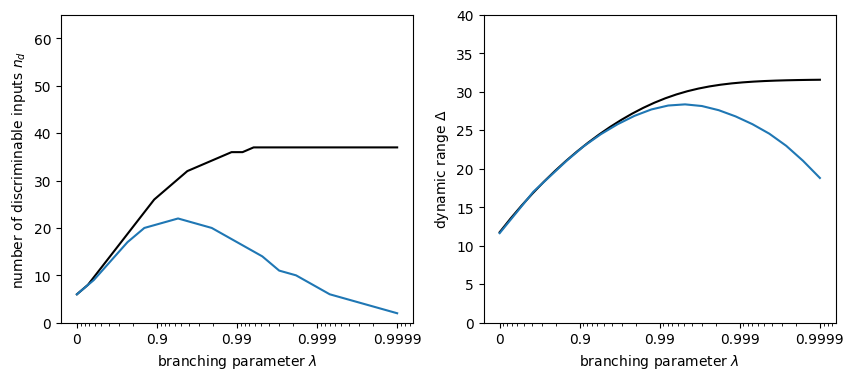

In [ ]:
# plot the number of discriminable inputs for different values of epsilon and T in a main plot with an inset
markers = ["o", "s", "^", "P", "d"]
legends = ["$1$ ms", "$10$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(1 - lams_inf, nds_inf, label="inf", color="black")
ax[0].plot(1 - lams, nds)
ax[0].set_xlabel("branching parameter $\lambda$")
ax[0].set_ylim(0, 65)
ax[0].set_ylabel("number of discriminable inputs $n_d$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[1].plot(1 - lams_inf, drs_inf, label="inf", color="black")
ax[1].plot(1 - lams, drs)
ax[1].set_xlabel("branching parameter $\lambda$")
ax[1].set_ylim(0, 40)
ax[1].set_ylabel("dynamic range $\Delta$")
ax[1].set_xscale("log")
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[1].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[1].invert_xaxis()